In [1]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.transforms import transforms, autoaugment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\myxo-vs-nonmyso(soran-archan)-augmented'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['myxo', 'nonmyxo']
Dataset sizes: {'train': 8000, 'val': 1600}


In [3]:
print(len(datasets['train']))
print(len(dataloaders['train']))

8000
250


In [4]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class, transform=None, num_magnitude_bins=30):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_samples_per_class (int): Desired number of samples per class after augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = ImageFolder(root=root_dir)
        self.classes = self.dataset.classes
        self.num_samples_per_class = num_samples_per_class
        self.transform = transform
        self.augment_transform = transforms.Compose([
            autoaugment.TrivialAugmentWide(num_magnitude_bins=num_magnitude_bins),
            transforms.ToTensor(),
        ])
        self.class_samples = self._balance_classes()

    def _balance_classes(self):
        from collections import defaultdict
        class_indices = defaultdict(list)
        
        for idx, (_, class_id) in enumerate(self.dataset.samples):
            class_indices[class_id].append(idx)
        
        # Reduce or oversample class indices to match num_samples_per_class
        balanced_indices = []
        for indices in class_indices.values():
            if len(indices) >= self.num_samples_per_class:
                balanced_indices.extend(indices[:self.num_samples_per_class])
            else:
                # Oversample if there are fewer samples than desired
                oversampled_indices = indices * (self.num_samples_per_class // len(indices)) + indices[:self.num_samples_per_class % len(indices)]
                balanced_indices.extend(oversampled_indices)
                
        return balanced_indices

    def __len__(self):
        return len(self.class_samples)

    def __getitem__(self, idx):
        img, label = self.dataset[self.class_samples[idx]]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = self.augment_transform(img)
        return img, label
    
    def classes(self):
        return self.classes

In [5]:
# # Define Parameters
# data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo2'
# num_magnitude_bins = 100
# train_num_samples_per_class = 2000
# val_num_samples_per_class = 300
# 
# # Define any additional transformations
# aug_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Flipping the image horizontally
#     transforms.RandomRotation(degrees=20),  # Rotate by -20 to +20 degrees
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation
#     transforms.ColorJitter(brightness=0.2),  # Adjusting Brightness
#     transforms.ColorJitter(contrast=0.2),
#     transforms.ToTensor(), 
#     transforms.Resize((224, 224))# Adjusting Contrast
# ])
# 
# 
# # Creating datasets
# # datasets = {
# #     x: CustomAugmentedDataset(root_dir=os.path.join(data_path, x),   num_magnitude_bins=num_magnitude_bins, num_samples_per_class=num_samples_per_class if x == 'train' else 5000) 
# #     for x in ['train', 'val']
# # }
# datasets = {
#     'train': CustomAugmentedDataset(root_dir=os.path.join(data_path, 'train'), num_magnitude_bins=num_magnitude_bins, transform=aug_transform,
#                                     num_samples_per_class=train_num_samples_per_class),
#     'val': CustomAugmentedDataset(root_dir=os.path.join(data_path, 'val'),
#                                   num_magnitude_bins=num_magnitude_bins,
#                                   num_samples_per_class=val_num_samples_per_class),
# }
# print('Datasets created.')
# 
# # Creating dataloaders
# batch_size = 32
# dataloaders = {
#     x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=5, shuffle=True if x == 'train' else False,
#                   drop_last=True)
#     for x in ['train', 'val']
# }
# print('Dataloaders created.')
# print('-' * 50)
# 
# # Show Classes
# class_names = datasets['train'].classes
# print(f'there are {len(class_names)} classes, and class names are {class_names}')
# print('-' * 50)
# 
# # Show datasets length 
# print('train dataset: ', len(datasets['train']))
# print('val dataset: ', len(datasets['val']))

In [6]:
# import matplotlib.pyplot as plt
# 
# idx = np.random.randint(0, 60000, size=1)
# 
# print('idx: ', int(idx))
# print('idx type: ', type(idx))
# image, label = datasets['train'][int(idx)]
# print('image type: ', type(image))
# print('label: ', label)
# print('class name label: ', class_names[label])
# 
# # Convert torch tensor for plotting
# image = image.permute(1, 2, 0)
# plt.grid(False)
# plt.axis('off')
# plt.imshow(image)
# plt.show()

In [7]:
dinov2_vits14_reg_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

# Define model
model = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model.head = nn.Sequential(
    nn.Linear(384, 33)
)
print(dinov2_vits14_reg_21M)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 125:
        break

Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [8]:
from datetime import datetime
from easydict import EasyDict
import copy


# train function 
def train_model(model, criterion, optimizer, dataloaders, epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / (len(dataloaders[phase]) * batch_size)
            epoch_accuracy = running_corrects / (len(dataloaders[phase]) * batch_size)

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print('-' * 50)

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

In [9]:
def reset_weights(layer):
    '''
      Try resetting layer weights to avoid
      weight leakage.
    '''
    if hasattr(layer, 'reset_parameters'):
        # print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [10]:
def reset_model_weights(model):
    for child in model.children():
        for layer in child.children():
            reset_weights(layer)
            if hasattr(layer, 'children'):
                for layer in layer.children():
                    reset_weights(layer)
                    if hasattr(layer, 'children'):
                        for layer in layer.children():
                            reset_weights(layer)
            else:
                reset_weights(layer)
    print('model weights reset!')


reset_model_weights(model)

model weights reset!


In [11]:
# Defining hyperparameters
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
data_path2 = 'D:\Master Project\model\model-1\myxo-vs-nonmyso(soran-archan)-augmented-kfold'
fold_dataset = ImageFolder(root=data_path2, transform=data_transforms['train'])
class_names = fold_dataset.classes
print(len(fold_dataset))

your device is cuda

9600


idx:  4907
idx type:  <class 'numpy.ndarray'>
image type:  <class 'torch.Tensor'>
label:  1
class name label:  nonmyxo


C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_16316\3647977109.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('idx: ', int(idx))
C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_16316\3647977109.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image, label = fold_dataset[int(idx)]


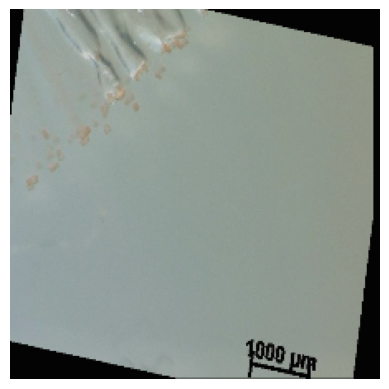

In [12]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(fold_dataset), size=1)

print('idx: ', int(idx))
print('idx type: ', type(idx))
image, label = fold_dataset[int(idx)]
print('image type: ', type(image))
print('label: ', label)
print('class name label: ', class_names[label])

# Convert torch tensor for plotting
image = image.permute(1, 2, 0)
plt.grid(False)
plt.axis('off')
plt.imshow(image)
plt.show()

In [ ]:
fold_acc_lists = []
fold_loss_lists = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(fold_dataset)):
    fold_time_0 = datetime.now()
    # Print
    print('-|-' * 50)
    print(f'FOLD {fold + 1} / {k_folds}')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = DataLoader(fold_dataset, batch_size=batch_size, sampler=train_subsampler)
    testloader = DataLoader(fold_dataset, batch_size=batch_size, sampler=test_subsampler)
    # print(len(trainloader))
    # print(len(testloader))
    fold_dataloaders = {
        'train': trainloader,
        'val': testloader
    }
    
    # Reset model weights for this fold
    reset_model_weights(model)

    optimizer = Adam(model.parameters(), lr=0.0001)

    model = model.to(device)

    # train model
    model, acc_lists, loss_lists = train_model(model, criterion, optimizer, dataloaders, epoch_num=5)
    fold_acc_lists.append(acc_lists)
    fold_loss_lists.append(loss_lists)
    
    # Saving the model
    save_path = f'../fold_models/model-fold-{fold + 1}.pth'
    torch.save(model.state_dict(), save_path)
    
    fold_delta_time = fold_time_0 - datetime.now()
    print(f'FOLD {fold + 1} finished in time: {fold_delta_time}')

-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|-
FOLD 1 / 5
model weights reset!
Epoch 1/5:
Train Accuracy: 0.9840 | Loss: 0.1314 | time: 0:00:33.205312
Val Accuracy: 0.5000 | Loss: 8.5383 | time: 0:00:07.387526
Best model weights updated!
--------------------------------------------------
Epoch 2/5:


In [ ]:
print(fold_acc_lists[0])